# Regrid NLDAS data to a WRF grid
## Alejandro (Lejo) Flores
## LEAF Research / Boise State University
## 21 January 2018

The purpose of this Jupyter notebook is to show how to resample precipitation data from the North American Land Data Assimilation System (NLDAS) from it's native 0.125${}^{\circ}$ resolution grid, to a WRF grid with a 1 km resolution. This is meant as a simple example that uses some key community libraries to accomplish this regridding.

The libraries used in particular, and their purpose in the context of this Jupyter notebook, are:
* pygrib -> Read NLDAS data in grib format
* numpy -> Used as the container for the grids (to do: use xarray instead)
* netCDF4 -> Read WRF latitude and longitude grids from netCDF format
* matplotlib -> Used to plot to verify the workflow
* xESMF -> Used as the regridder. This is a great tool that serves as an xarray enabled front-end to ESMPy. Check it out here: http://xesmf.readthedocs.io/en/latest/index.html

The workflow goes like this:
1. Import the libraries
2. Read in the WRF latitude and longitude grids (the target grid) using netCDF4. Verify using pyplot.
3. Read the NLDAS latitude, longitude, and precipitation data using pygrib. Verify using pyplot.
4. Define the input and output grids for xESMF (using the numpy implementation)
5. Use xESMF to get the weights for regridding
6. Use the regridder to resample the NLDAS data
7. Plot to verify

## 1. Import libraries

In [1]:
import pygrib as pg
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import xesmf as xe

## 2. Define key constants and file names

In [2]:
# Spatial resolution of the NLDAS data
NLDAS_res = 0.125

# NLDAS file name (Grib file)
nldas_file = 'NLDAS_FORA0125_H.A20100603.0800.002.grb'

# Names of the NetCDF files containing the XLAT and XLONG variables. Note that
# in this case I just used the ncks utility in the NetCDF Climate Operators (NCO)
# package to subset the XLAT and XLONG variables into new files from the wrfout
# output files from some simulations
wrf_lat_file = 'xlat_d02.nc'
wrf_lon_file = 'xlong_d02.nc'

## 3. Open the WRF latitute and longitude grids and plot

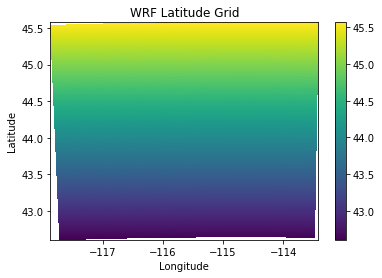

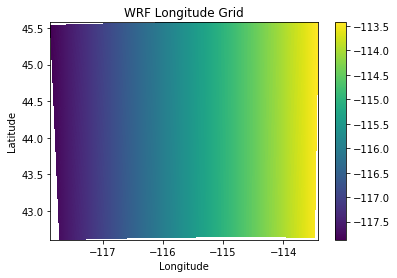

In [ ]:
# Open those NetCDF files 
nc_wrf_lat_fid = nc.Dataset(wrf_lat_file, 'r')
nc_wrf_lon_fid = nc.Dataset(wrf_lon_file, 'r')

wrf_lats = nc_wrf_lat_fid.variables['XLAT'][0,:,:]
wrf_lons = nc_wrf_lon_fid.variables['XLONG'][0,:,:]

wrf_lon_b, wrf_lat_b = np.meshgrid(np.linspace(wrf_lons.min(), wrf_lons.max(), (np.size(wrf_lons,1)+1)), 
                                   np.linspace(wrf_lats.min(), wrf_lats.max(), (np.size(wrf_lats,0)+1)))

plt.pcolor(wrf_lons,wrf_lats,wrf_lats)
plt.title('WRF Latitude Grid')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()
plt.show()

plt.pcolor(wrf_lons,wrf_lats,wrf_lons)
plt.title('WRF Longitude Grid')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()
plt.show()

## 4. Open the NLDAS latitute, longitude, and precipitation grids and plot

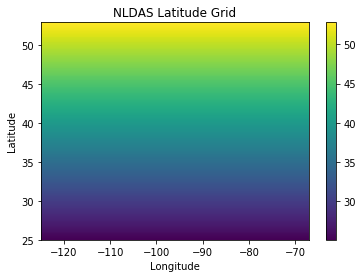

In [ ]:
# Open the NLDAS grib file 
grbs = pg.open(nldas_file) # Open the file
grb = grbs[10] # Get the 10th variable, which is precipitation

nldas_prcp = grb.values
nldas_lat,nldas_lon = grb.latlons()

nldas_lon_b, nldas_lat_b = np.meshgrid(np.linspace(nldas_lon.min(), nldas_lon.max(), (np.size(nldas_lon,1)+1)), 
                                   np.linspace(nldas_lat.min(), nldas_lat.max(), (np.size(nldas_lat,0)+1)))


plt.pcolor(nldas_lon,nldas_lat,nldas_lat)
plt.title('NLDAS Latitude Grid')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()
plt.show()

plt.pcolor(nldas_lon,nldas_lat,nldas_lon)
plt.title('NLDAS Longitude Grid')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()
plt.show()

plt.pcolor(nldas_lon,nldas_lat,nldas_prcp)
plt.title('NLDAS Precipitation Grid')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()
plt.show()

## 5. Define the input and output grids for the regridding function

In [ ]:
grid_nldas_in = {'lon': nldas_lon,
                 'lat': nldas_lat,
                 'lon_b': nldas_lon_b,
                 'lat_b': nldas_lat_b
                }

grid_wrf_out  = {'lon': wrf_lons,
                 'lat': wrf_lats,
                 'lon_b': wrf_lon_b,
                 'lat_b': wrf_lat_b
                }

## 6. Use xESMF to get the regridding weight file

In [ ]:
regridder = xe.Regridder(grid_nldas_in, grid_wrf_out, 'conservative')
regridder.clean_weight_file()
regridder

## 7. Use the regridder to downsample the NLDAS data and plot

In [ ]:
# Invoke regridder
nldas_prcp_wrf = regridder(nldas_prcp)

plt.pcolor(wrf_lons,wrf_lats,nldas_prcp_wrf)
plt.title('NLDAS Precipitation, Resampled to 1km WRF Grid')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()
plt.show()
